In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import optimize

# Environment Setup

In [2]:
class StochasticPricingEnvironment:
    """
    Stochastic environment with a distribution over customer valuations for a single product.
    The demand probability depends on the price and the distribution of customer valuations.
    """
    def __init__(self, valuation_distribution, demand_noise_std=0.1):
        """
        Args:
            valuation_distribution: A scipy.stats distribution representing customer valuations
            demand_noise_std: Standard deviation of noise in demand probability
        """
        self.valuation_dist = valuation_distribution
        self.noise_std = demand_noise_std
        
    def demand_probability(self, price):

        return 1 - self.valuation_dist.cdf(price) #probability that the valuation is bigger than the price

    def simulate_round(self, price):
        #base_prob = self.demand_probability(price)
        # Noise solo durante la simulazione
        #noise = np.random.normal(0, self.noise_std)
        #actual_prob = np.clip(base_prob + noise, 0, 1) #add a noise
        
        valuation = self.valuation_dist.rvs()

        sale_made = 1 if valuation >= price else 0 #if the valuation is bigger than the price, a sale is made
        revenue = sale_made * price #compute the revenue
        return sale_made, revenue

# Agent Setup

In [273]:
# the agent does not need the values of the available bids or the valuation
# the first bid is 0
class UCBLikeAgent():
    def __init__(self, P, T,prices, confidence_bound=2,rho_penalty=1.0):
        
        k=len(prices)

        self.prices=prices #vector of prices
        self.K = k #number of arms
        self.T = T #nuber of rounds
        self.confidence_bound = confidence_bound #conf parametere for UCB and LCB
        
        self.current_price_idx = None # it's an index, not the actual bid
        
        self.avg_revenue = np.zeros(k) #average revenue
        self.avg_demand = np.zeros(k)  # Average demand (purchase probability)
        
        self.N_pulls = np.zeros(k)#number of pulls for each price
        self.inventory = P #prod_cmonstr
        self.rho = P/T #rho
        self.remaining_inventory = P #remaining inventory
        self.rho_penalty = rho_penalty #penalty for rho, can be adjusted
        self.t = 0 #selected timestep

        self.history = {'prices': [], 'rewards': [], 'purchases': [], 'inventory': []}
    
    def select_price(self):
        if self.remaining_inventory < 1: #if no more products in the inventory
            self.current_price_idx = np.argmax(self.prices)
            return  np.nan #no price can be selected
            
        if self.t < self.K:
            self.current_price_idx = self.t  #we explore all the possible prices till time K
        else:
            f_ucbs = self.avg_revenue + self.confidence_bound*np.sqrt(2*np.log(self.T)/self.N_pulls) #compute f_UBCs (for each price)
            c_lcbs = np.maximum(0,self.avg_demand - self.confidence_bound*np.sqrt(2*np.log(self.T)/self.N_pulls))#compute avg_demand_LCBs (for each price)
            
            gamma_t = self.compute_opt(f_ucbs,c_lcbs)#best distribution
            
            self.current_price_idx = np.random.choice(self.K, p=gamma_t)#select the best idx

        return self.prices[self.current_price_idx] #selected price

    def compute_opt(self, f_ucbs, c_lcbs): 
        
        if np.sum(c_lcbs <= np.zeros(len(c_lcbs))): #if no demand expected, choose the price with the actual highest reward
            gamma = np.zeros(len(f_ucbs)) #set to 0 each probabilities
            gamma[np.argmax(f_ucbs)] = 1 #set to \1 the best
            return gamma
        
        c = -f_ucbs
        
        current_rho = max(self.remaining_inventory / max(1, self.T - self.t), 0)

        penalized_rho = current_rho*self.rho_penalty # penalty for rho, can be adjusted 

        A_ub = [c_lcbs]
        b_ub = [penalized_rho]
        
        A_eq = [np.ones(self.K)]
        b_eq = [1]
        
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
        gamma = res.x
        return gamma
    
    def update(self, reward, purchased):
        idx = self.current_price_idx
        
        self.N_pulls[idx] += 1
        self.avg_revenue[idx] += (reward - self.avg_revenue[idx])/self.N_pulls[idx]
        
        purchased_indicator = 1 if purchased else 0.0
        self.avg_demand[idx] += (purchased_indicator - self.avg_demand[idx])/self.N_pulls[idx]
        
        # FIX: Solo se c'è inventario E c'è stata una vendita
        if purchased and self.remaining_inventory > 0:
            self.remaining_inventory -= 1
            # Il revenue rimane quello calcolato dall'environment
        elif purchased and self.remaining_inventory <= 0:
            # Vendita richiesta ma inventario vuoto -> no revenue
            reward = 0
            purchased = False
        
        # Log history
        self.history['prices'].append(self.prices[idx])
        self.history['rewards'].append(reward)
        self.history['purchases'].append(purchased)
        self.history['inventory'].append(self.remaining_inventory)
        self.t += 1


    def get_best_price(self):
        """
        Return the price with highest average revenue so far.
        """
        best_idx = np.argmax(self.avg_revenue)
        return self.prices[best_idx], self.avg_revenue[best_idx]    

**Enviroment Configuration**


In [274]:
# Environment Configuration
env_config = {
    'valuation_mean': 50,  # Average customer valuation
    'valuation_std': 15,   # Standard deviation of customer valuations
    'demand_noise_std': 0.005  # Noise in demand probability
}

## Create a normal distribution for customer valuations
valuation_dist = stats.norm(loc=env_config['valuation_mean'], scale=env_config['valuation_std'])

T = 1000  # Number of rounds
inventory = 400  # Inventory constraint

agent_params = {
   
    
    'P': inventory, #inv constr
    'T': T, #number of rounds
    'prices': [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80], #set of prices  #
    #'prices': [20,50,80], #set of prices 
    'confidence_bound': 1,  # UCB exploration parameter
    'rho_penalty': 0.7  

}

agent = UCBLikeAgent(**agent_params)

print(f"Customer valuation distribution: Normal(μ={env_config['valuation_mean']}, σ={env_config['valuation_std']})")
print(f"Number of price options: {len(agent_params['prices'])}")
print(f"UCB confidence bound: {agent_params['confidence_bound']}")
print(f'Inventory contrain: ',agent_params['P'])
print(f'Number of rounds:',agent_params['T'])

# set random seed for reproducibility
np.random.seed(42)

Customer valuation distribution: Normal(μ=50, σ=15)
Number of price options: 13
UCB confidence bound: 1
Inventory contrain:  400
Number of rounds: 1000


In [276]:
#define the optimal solution

def compute_clairvoyant(prices,environment,T,P):
    
    buying_probabilities=np.array([environment.demand_probability(p) for p in prices])
    exp_reward=prices*buying_probabilities

    c= -exp_reward
    A_ub = [buying_probabilities]
    b_ub = [P/T]
    A_eq = [np.ones(len(prices))]
    b_eq = [1]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    
    gamma = res.x
    
    
    optimal_value = -res.fun
    
    return gamma, optimal_value, buying_probabilities, exp_reward

**Theoretical Analysis**

In [278]:

print('=== Theoretical Analysis ===')

env=StochasticPricingEnvironment(valuation_distribution=valuation_dist,demand_noise_std=env_config['demand_noise_std'])



opt_dist, opt_value, true_purchase_probs, true_rewards=compute_clairvoyant(prices=agent_params['prices'],environment=env,T=agent_params['T'],P=agent_params['P'])

optimal_idx = np.argmax(opt_dist)  # Index of the optimal price

for i in range(len(agent_params['prices'])):
    
    prices=agent_params['prices']
    marker = " ← OPTIMAL" if i == optimal_idx else ""
    print(f"  Price {prices[i]:2d}: p ={opt_dist[i]:5.1f}{marker}")

optimal_revenue = np.dot(prices, opt_dist)

print(f'\n=== Optimal revenue === \n         {optimal_revenue:.2f}')




=== Theoretical Analysis ===
  Price 20: p =  0.0
  Price 25: p =  0.0
  Price 30: p =  0.0
  Price 35: p =  0.0
  Price 40: p =  0.0
  Price 45: p =  0.0
  Price 50: p =  0.2
  Price 55: p =  0.8 ← OPTIMAL
  Price 60: p =  0.0
  Price 65: p =  0.0
  Price 70: p =  0.0
  Price 75: p =  0.0
  Price 80: p =  0.0

=== Optimal revenue === 
         53.83


# Simulation

In [280]:
def run_simulator(
    T,
    valuation_dist,
    env_config,
    agent_params,
    n_simulations=1,
    verbose=True
):
    selected_prices = []
    revenues = []
    sales = []
    cumulative_revenue = []
    total_revenue = 0
    best_prices = []
    first_inventory_empty = None

    # === Compute theoretical optimum once before all simulations ===
    env_theoretical = StochasticPricingEnvironment(
        valuation_distribution=valuation_dist,
        demand_noise_std=env_config['demand_noise_std']
    )
    opt_dist, opt_value, true_purchase_probs, true_rewards = compute_clairvoyant(
        prices=agent_params['prices'],
        environment=env_theoretical,
        T=agent_params['T'],
        P=agent_params['P']
    )
    optimal_idx = np.argmax(opt_dist)
    optimal_revenue = np.dot(agent_params['prices'], opt_dist)


    for sim in range(n_simulations):
        if verbose:
            print(f"\n=== Running UCB1 Pricing Simulation #{sim + 1} for {T} rounds ===")

        # Create environment and agent
        env = StochasticPricingEnvironment(
            valuation_distribution=valuation_dist,
            demand_noise_std=env_config['demand_noise_std']
        )
        agent = UCBLikeAgent(**agent_params)

        for t in range(T):
            if agent.remaining_inventory < 1 and first_inventory_empty is None:
                first_inventory_empty = t
                if verbose:
                    print(f"Inventory empty for the first time at round {t}")
                    print("No more products in the inventory")

            price = agent.select_price()
            price_idx = agent.current_price_idx

            if agent.remaining_inventory <= 0:
                sale_made = False
                revenue = 0
            else:
                sale_made, revenue = env.simulate_round(price)

            agent.update(revenue, sale_made)

            selected_prices.append(price)
            revenues.append(revenue)
            sales.append(sale_made)
            total_revenue += revenue
            cumulative_revenue.append(total_revenue)

        best_price, best_avg_revenue = agent.get_best_price()
        best_prices.append(best_price)

        if verbose:
            print(f"\nSimulation completed!")
            print(f"Total revenue: {total_revenue:.2f}")
            print(f"Average revenue per round: {total_revenue / T:.2f}")
            print(f"Agent's best price: {best_price} (avg revenue: {best_avg_revenue:.2f})")
            print(f"Theoretical optimal: {opt_dist} (expected revenue: {optimal_revenue:.2f})")

    price_to_idx = {p: i for i, p in enumerate(agent_params['prices'])}
    price_indices = [price_to_idx[p] for p in selected_prices if not np.isnan(p)]
    price_counts = np.bincount(price_indices, minlength=len(agent_params['prices']))        

    if verbose:
        print("\n=== Simulation Results ===")
        print("\nPrice selection frequency:")
        for i, (price, count) in enumerate(zip(agent_params['prices'], price_counts)):
            percentage = 100 * count / T
            marker = " ← OPTIMAL" if i == optimal_idx else ""
            print(f"  Price {price:2}: {count:4d} times ({percentage:5.1f}%){marker}")

    return {
        'price_counts': price_counts,
        'selected_prices': selected_prices,
        'revenues': revenues,
        'sales': sales,
        'cumulative_revenue': cumulative_revenue,
        'best_prices': best_prices,
        'first_inventory_empty': first_inventory_empty,
        'total_revenue': total_revenue,
        'opt_dist': opt_dist,
        'optimal_idx': optimal_idx,
        'optimal_revenue': optimal_revenue
    }


# Plot

In [281]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(T, revenues, cumulative_revenue, price_counts, 
                 agent_params, sales, agent, valuation_dist, env_config):
    # === Theoretical Analysis ===
    print('=== Theoretical Analysis ===')

    env = StochasticPricingEnvironment(
        valuation_distribution=valuation_dist,
        demand_noise_std=env_config['demand_noise_std']
    )

    opt_dist, opt_value, true_purchase_probs, true_rewards = compute_clairvoyant(
        prices=agent_params['prices'],
        environment=env,
        T=agent_params['T'],
        P=agent_params['P']
    )

    prices = agent_params['prices']
    optimal_idx = np.argmax(opt_dist)
    for i in range(len(prices)):
        marker = " ← OPTIMAL" if i == optimal_idx else ""
        print(f"  Price {prices[i]:2d}: p = {opt_dist[i]:5.1f}{marker}")

    optimal_revenue = np.dot(prices, opt_dist)
    print(f'\n=== Optimal revenue === \n         {optimal_revenue:.2f}')

    # === Performance Analysis ===
    theoretical_optimal_total = optimal_revenue * T
    total_revenue = sum(revenues)
    actual_regret = theoretical_optimal_total - total_revenue
    regret_cumulative = [optimal_revenue * (t+1) - cumulative_revenue[t] for t in range(T)]

    # === Comprehensive Visualization ===
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Cumulative Revenue vs Optimal
    axes[0, 0].plot(cumulative_revenue, label='UCB Agent', linewidth=2)
    axes[0, 0].plot([optimal_revenue * (t+1) for t in range(T)], 
                    label='Theoretical Optimal', linestyle='--', linewidth=2)
    axes[0, 0].set_xlabel('Round')
    axes[0, 0].set_ylabel('Cumulative Revenue')
    axes[0, 0].set_title('Cumulative Revenue Comparison')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Cumulative Regret
    axes[0, 1].plot(range(T), range(T), label='T', color='blue', linewidth=2)
    axes[0, 1].plot(regret_cumulative, color='red', linewidth=2)
    axes[0, 1].set_xlabel('Round')
    axes[0, 1].set_ylabel('Cumulative Regret')
    axes[0, 1].set_title('Cumulative Regret Over Time')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Price Selection Frequency
    bars = axes[1, 0].bar(prices, price_counts, alpha=0.7)
    bars[optimal_idx].set_color('red')
    bars[optimal_idx].set_alpha(1.0)
    axes[1, 0].set_xlabel('Price')
    axes[1, 0].set_ylabel('Selection Frequency')
    axes[1, 0].set_title('Price Selection Distribution')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Revenue per Round (moving average)
    window_size = 50
    moving_avg = np.convolve(revenues, np.ones(window_size)/window_size, mode='valid')
    axes[1, 1].plot(range(window_size-1, T), moving_avg, linewidth=2)
    axes[1, 1].axhline(optimal_revenue, color='red', linestyle='--', 
                       label=f'Optimal ({optimal_revenue:.2f})')
    axes[1, 1].set_xlabel('Round')
    axes[1, 1].set_ylabel('Revenue (Moving Average)')
    axes[1, 1].set_title(f'Revenue Convergence (Window={window_size})')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    



    plt.tight_layout()
    plt.show()

    # === Average Regret per Round: R(t)/t ===
    t_vals = np.arange(1, T + 1)
    regret_avg = np.array(regret_cumulative) / t_vals

    plt.figure(figsize=(10, 5))
    plt.plot(t_vals, regret_avg, label=r'$R(t)/t$', linewidth=2)
    plt.title("Average Regret Per Round")
    plt.xlabel("Round")
    plt.ylabel("Average Regret")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    from scipy.stats import linregress

    t_vals = np.arange(1, T + 1)
    log_t = np.log(t_vals)
    log_regret = np.log(np.maximum(regret_cumulative, 1e-6))  # evita log(0)
    slope, *_ = linregress(log_t, log_regret)

    print(f"Estimated regret exponent (slope): {slope:.3f}")

    # === Summary Statistics ===
    print(f"\n=== Summary Statistics ===")
    print(f"Convergence rate: {100 * (1 - actual_regret/theoretical_optimal_total):.1f}%")
    print(f"Average revenue per round: {total_revenue/T:.2f}")
    print(f"Std dev of revenues: {np.std(revenues):.2f}")
    print(f"Total sales made: {sum(sales)}")
    print(f"Sales rate: {100 * sum(sales)/T:.1f}%")
    print(f"Remaining inventory: {agent.remaining_inventory}")
    print(f"Total regret: {actual_regret:.2f}")
    print(f"Average regret per round: {actual_regret/T:.4f}")

    return{

        'cumulative_regret': regret_cumulative,
        'cumulative_revenue': cumulative_revenue,

    }


# Define the agent and the enviroment


In [297]:
env_config = {
    'valuation_mean': 50,  # Average customer valuation
    'valuation_std': 30,   # Standard deviation of customer valuations
    'demand_noise_std': 0.005  # Noise in demand probability
}

valuation_dist = stats.norm(loc=env_config['valuation_mean'], scale=env_config['valuation_std'])

T = 10000  # Number of rounds
inventory = 4000  # Inventory constraint
agent_params = {
   
    
    'P': inventory, #inv constr
    'T': T, #number of rounds
    #'prices': [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80], #set of prices  #
    #'prices': [20, 30,40,50,60,70,80], #set of prices
    'prices': [20,50,80], #set of prices 
    'confidence_bound': 10,  # UCB exploration parameter
    'rho_penalty': 1

}

# Run the simulation

In [298]:
results = run_simulator(
    T=T,
    valuation_dist=valuation_dist,
    env_config=env_config,
    agent_params=agent_params,
    n_simulations=1,
    verbose=True
)

selected_prices = results['selected_prices']
revenues = results['revenues']
sales = results['sales']
cumulative_revenue = results['cumulative_revenue']
best_prices = results['best_prices']
first_inventory_empty = results['first_inventory_empty']
total_revenue = results['total_revenue']
price_counts = results['price_counts']


=== Running UCB1 Pricing Simulation #1 for 10000 rounds ===
Inventory empty for the first time at round 7966
No more products in the inventory

Simulation completed!
Total revenue: 198950.00
Average revenue per round: 19.89
Agent's best price: 50 (avg revenue: 25.02)
Theoretical optimal: [0.         0.70704105 0.29295895] (expected revenue: 58.79)

=== Simulation Results ===

Price selection frequency:
  Price 20:   38 times (  0.4%)
  Price 50: 7925 times ( 79.2%) ← OPTIMAL
  Price 80:    3 times (  0.0%)


# Plot the results

=== Theoretical Analysis ===
  Price 20: p =   0.0
  Price 50: p =   0.7 ← OPTIMAL
  Price 80: p =   0.3

=== Optimal revenue === 
         58.79


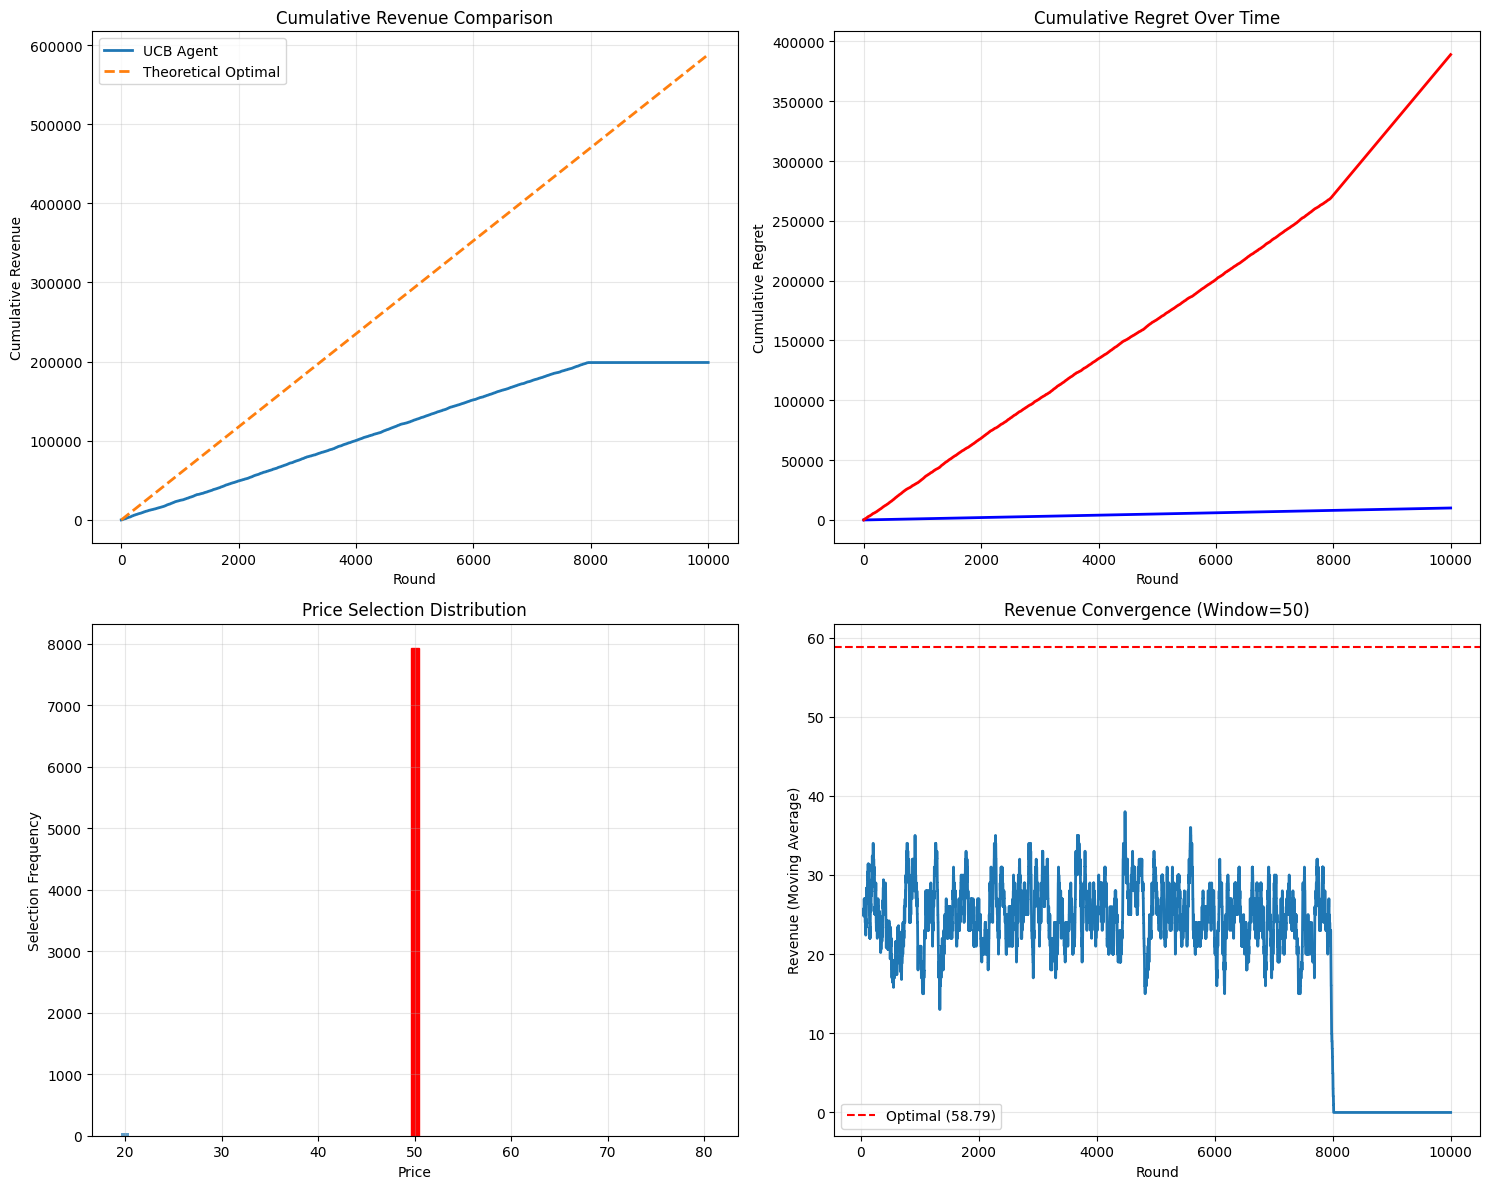

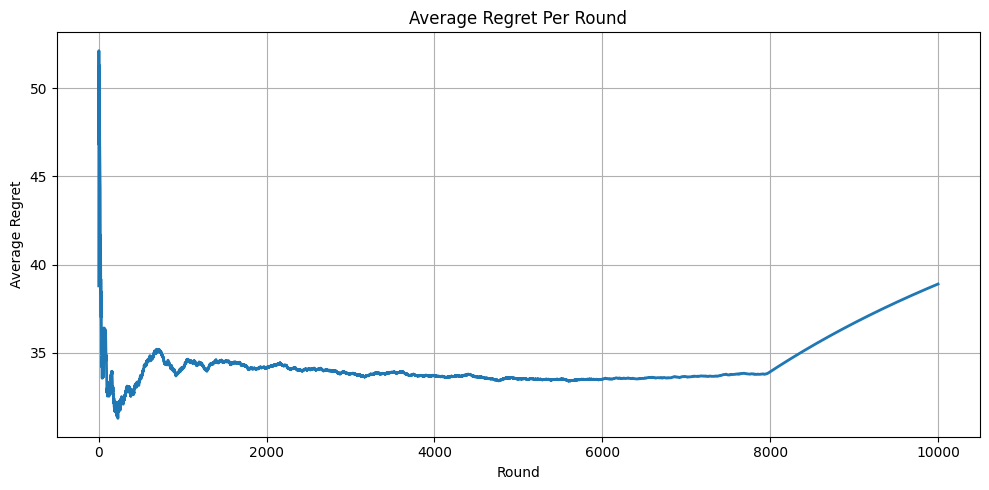

Estimated regret exponent (slope): 1.008

=== Summary Statistics ===
Convergence rate: 33.8%
Average revenue per round: 19.89
Std dev of revenues: 24.43
Total sales made: 4000
Sales rate: 40.0%
Remaining inventory: 400
Total regret: 388937.69
Average regret per round: 38.8938


In [299]:
plot_res=plot_results(T, revenues, cumulative_revenue, price_counts, 
                 agent_params, sales, agent, valuation_dist, env_config)



=== Generating Visualizations ===


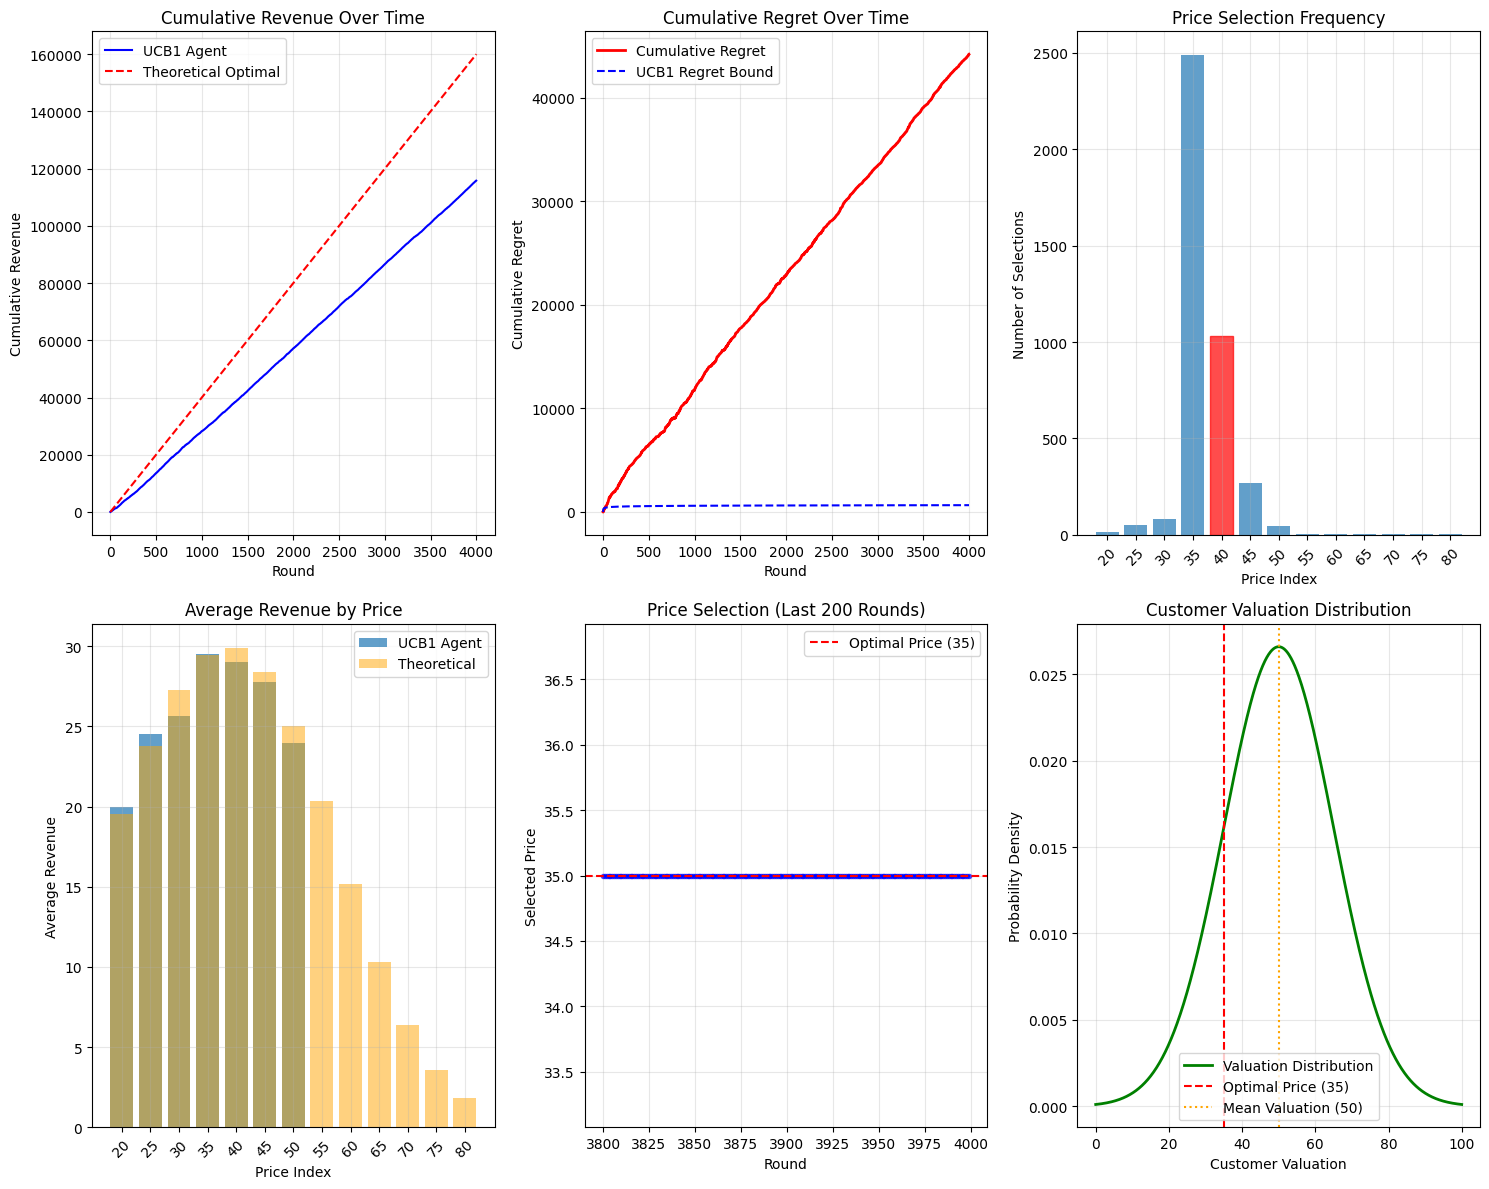

In [301]:
# Visualization
print("\n=== Generating Visualizations ===")



plt.figure(figsize=(15, 12))

# 1. Cumulative Revenue over Time
plt.subplot(2, 3, 1)
plt.plot(cumulative_revenue, 'b-', label='UCB1 Agent')
plt.plot([0, T], [0, theoretical_optimal_total], 'r--', label='Theoretical Optimal')
plt.xlabel('Round')
plt.ylabel('Cumulative Revenue')
plt.title('Cumulative Revenue Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Regret of the agent vs UCB1 regret bound
plt.subplot(2, 3, 2)
plt.plot(regret_cumulative, 'r-', linewidth=2, label='Cumulative Regret')

# UCB1 regret bound: O(sqrt(K log T) T)
K = len(agent_params['prices'])
ucb1_bound = np.sqrt(K * np.log(np.arange(1, T + 1))) * np.sqrt(T)
plt.plot(np.arange(1, T + 1), ucb1_bound, 'b--', label='UCB1 Regret Bound')

plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Price Selection Frequency
plt.subplot(2, 3, 3)
bars = plt.bar(range(len(agent_params['prices'])), price_counts, alpha=0.7)
bars[optimal_idx].set_color('red')  # Highlight optimal price
plt.xlabel('Price Index')
plt.ylabel('Number of Selections')
plt.title('Price Selection Frequency')
plt.xticks(range(len(agent_params['prices'])), [f'{p}' for p in agent_params['prices']], rotation=45)
plt.grid(True, alpha=0.3)

# 4. Agent's Average Revenue vs Theoretical
plt.subplot(2, 3, 4)
plt.bar(range(len(agent_params['prices'])), agent.avg_revenue, alpha=0.7, label='UCB1 Agent')
plt.bar(range(len(agent_params['prices'])),  true_rewards, alpha=0.5, label='Theoretical', color='orange')
plt.xlabel('Price Index')
plt.ylabel('Average Revenue')
plt.title('Average Revenue by Price')
plt.xticks(range(len(agent_params['prices'])), [f'{p}' for p in agent_params['prices']], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Price Selection Over Time (last 200 rounds)
plt.subplot(2, 3, 5)
recent_prices = selected_prices[-200:]
recent_rounds = range(T-200, T)
plt.plot(recent_rounds, recent_prices, 'bo-', alpha=0.6, markersize=3)
plt.axhline(y=best_price, color='r', linestyle='--', label=f'Optimal Price ({best_price})')
plt.xlabel('Round')
plt.ylabel('Selected Price')
plt.title('Price Selection (Last 200 Rounds)')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Customer Valuation Distribution
plt.subplot(2, 3, 6)
x_vals = np.linspace(0, 100, 1000)
pdf_vals = valuation_dist.pdf(x_vals)
plt.plot(x_vals, pdf_vals, 'g-', linewidth=2, label='Valuation Distribution')
plt.axvline(x=best_price, color='r', linestyle='--', label=f'Optimal Price ({best_price})')
plt.axvline(x=env_config['valuation_mean'], color='orange', linestyle=':', label=f'Mean Valuation ({env_config["valuation_mean"]})')
plt.xlabel('Customer Valuation')
plt.ylabel('Probability Density')
plt.title('Customer Valuation Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Running Dynamic Pricing Experiment...
Requirement 1: Single product and stochastic environment
------------------------------------------------------------
Clairvoyant optimal distribution: [0.         0.         0.         0.         0.         0.
 0.         0.40622445 0.59377555 0.         0.         0.
 0.        ]
Clairvoyant optimal value per round: 17.2496


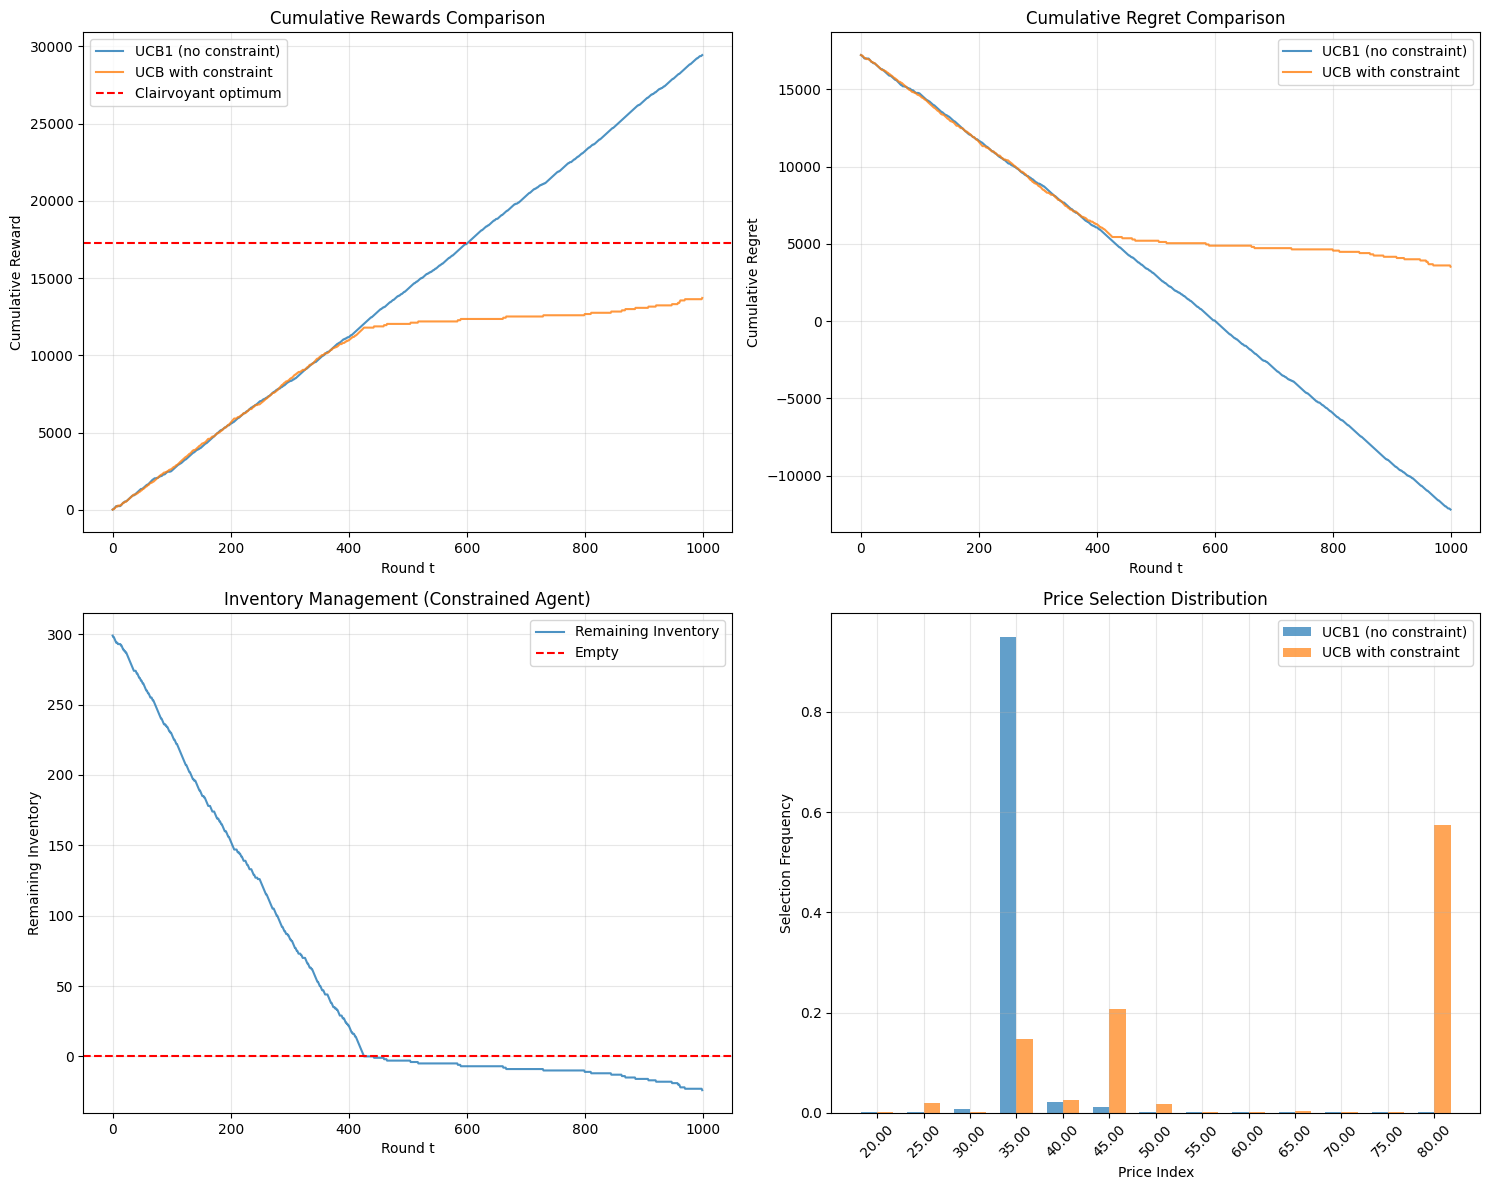


EXPERIMENT RESULTS SUMMARY
Time horizon T: 1000
Production capacity B: 300
Target consumption rate ρ: 0.300

Final Cumulative Rewards:
  UCB1 (no constraint): 29445.00
  UCB with constraint: 13720.00
  Clairvoyant optimum: 17249.62

Final Regret:
  UCB1 (no constraint): -12195.38
  UCB with constraint: 3529.62

Total Sales:
  UCB1 (no constraint): 839
  UCB with constraint: 324
  Remaining inventory (constrained): -24


In [164]:
#chat

import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import stats
import seaborn as sns

class StochasticPricingEnvironment:
    """
    Stochastic environment with a distribution over customer valuations for a single product.
    The demand probability depends on the price and the distribution of customer valuations.
    """
    def __init__(self, valuation_distribution, demand_noise_std=0.1, production_constr=100):
        """
        Args:
            valuation_distribution: A scipy.stats distribution representing customer valuations
            demand_noise_std: Standard deviation of noise in demand probability
            production_constr: Production constraint (inventory limit)
        """
        self.valuation_dist = valuation_distribution
        self.noise_std = demand_noise_std
        self.production_constr = production_constr
        
    def demand_probability(self, price):
        """
        Calculate the true underlying probability that a customer buys at given price.
        This is P(valuation >= price) without noise.
        """
        return 1 - self.valuation_dist.cdf(price)
        
    def simulate_round(self, price):
        """
        Simulate one pricing round with noise.
        Returns: (sale_made, revenue)
        """
        # Get base probability
        base_prob = self.demand_probability(price)
        
        # Add noise to make it stochastic
        noise = np.random.normal(0, self.noise_std)
        actual_prob = np.clip(base_prob + noise, 0, 1)
        
        # Simulate purchase decision
        sale_made = np.random.binomial(1, actual_prob)
        revenue = sale_made * price
        
        return sale_made, revenue


class UCB1PricingAgent:
    """
    UCB1 agent for dynamic pricing WITHOUT inventory constraint.
    This is the baseline algorithm ignoring production constraints.
    """
    def __init__(self, prices, T, range_val=1.0):
        self.prices = np.array(prices)
        self.K = len(prices)  # Number of available prices
        self.T = T  # Time horizon
        self.range_val = range_val  # Range for confidence bounds
        self.t = 0  # Current time step
        
        # Statistics for each price
        self.N_pulls = np.zeros(self.K)  # Number of times each price was chosen
        self.avg_reward = np.zeros(self.K)  # Average reward for each price
        
        self.chosen_price_idx = None
        self.history = {'prices': [], 'rewards': [], 'purchases': []}
    
    def select_price(self):
        """Select price using UCB1 strategy"""
        if self.t < self.K:
            # Exploration phase: try each price at least once
            self.chosen_price_idx = self.t
        else:
            # UCB1 selection
            ucb_values = self.avg_reward + self.range_val * np.sqrt(
                2 * np.log(self.t) / self.N_pulls
            )
            self.chosen_price_idx = np.argmax(ucb_values)
        
        return self.prices[self.chosen_price_idx]
    
    def update(self, reward, purchased):
        """Update statistics after observing outcome"""
        idx = self.chosen_price_idx
        self.N_pulls[idx] += 1
        
        # Update average reward incrementally
        self.avg_reward[idx] += (reward - self.avg_reward[idx]) / self.N_pulls[idx]
        
        # Log history
        self.history['prices'].append(self.prices[idx])
        self.history['rewards'].append(reward)
        self.history['purchases'].append(purchased)
        
        self.t += 1


class UCBPricingWithConstraint:
    """
    Extended UCB agent for dynamic pricing WITH inventory constraint.
    Uses primal-dual approach similar to the auction case.
    """
    def __init__(self, prices, B, T, range_val=1.0):
        self.prices = np.array(prices)
        self.K = len(prices)
        self.B = B  # Production capacity (total inventory)
        self.T = T  # Time horizon
        self.range_val = range_val
        self.t = 0
        
        # Statistics
        self.N_pulls = np.zeros(self.K)
        self.avg_reward = np.zeros(self.K)  # Average profit per unit sold
        self.avg_demand = np.zeros(self.K)  # Average demand (purchase probability)
        
        self.remaining_inventory = B
        self.rho = B / T  # Target inventory consumption rate
        
        self.chosen_price_idx = None
        self.history = {'prices': [], 'rewards': [], 'purchases': [], 'inventory': []}
    
    def select_price(self):
        """Select price using UCB with inventory constraint"""
        if self.remaining_inventory < 1:
            # No inventory left, choose highest price (least likely to sell)
            self.chosen_price_idx = np.argmax(self.prices)
            return self.prices[self.chosen_price_idx]
        
        if self.t < self.K:
            # Exploration phase
            self.chosen_price_idx = self.t
        else:
            # Compute UCB for rewards and LCB for demand
            reward_ucbs = self.avg_reward + self.range_val * np.sqrt(
                2 * np.log(self.T) / self.N_pulls
            )
            demand_lcbs = np.maximum(0, self.avg_demand - self.range_val * np.sqrt(
                2 * np.log(self.T) / self.N_pulls
            ))
            
            # Solve optimization problem
            gamma_t = self.compute_optimal_distribution(reward_ucbs, demand_lcbs)
            self.chosen_price_idx = np.random.choice(self.K, p=gamma_t)
        
        return self.prices[self.chosen_price_idx]
    
    def compute_optimal_distribution(self, reward_ucbs, demand_lcbs):
        """
        Solve the linear program to find optimal price distribution
        Similar to the auction case but adapted for pricing
        """
        if np.sum(demand_lcbs) <= 0:
            # If no demand expected, choose price with highest reward
            gamma = np.zeros(self.K)
            gamma[np.argmax(reward_ucbs)] = 1.0
            return gamma
        
        # Linear program: maximize expected reward subject to inventory constraint
        c = -reward_ucbs  # Negative because linprog minimizes
        
        # Constraint: expected demand <= target consumption rate
        A_ub = [demand_lcbs]
        b_ub = [self.rho]
        
        # Probability constraint: sum of probabilities = 1
        A_eq = [np.ones(self.K)]
        b_eq = [1.0]
        
        # Bounds: probabilities between 0 and 1
        bounds = [(0, 1) for _ in range(self.K)]
        
        try:
            result = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, 
                                    bounds=bounds, method='highs')
            if result.success:
                return result.x
            else:
                # Fallback: uniform distribution
                return np.ones(self.K) / self.K
        except:
            # Fallback: uniform distribution
            return np.ones(self.K) / self.K
    
    def update(self, reward, purchased):
        """Update statistics after observing outcome"""
        idx = self.chosen_price_idx
        self.N_pulls[idx] += 1
        
        # Update average reward (profit per unit sold)
        self.avg_reward[idx] += (reward - self.avg_reward[idx]) / self.N_pulls[idx]
        
        # Update average demand (purchase indicator)
        purchase_indicator = 1.0 if purchased else 0.0
        self.avg_demand[idx] += (purchase_indicator - self.avg_demand[idx]) / self.N_pulls[idx]
        
        # Update inventory
        if purchased:
            self.remaining_inventory -= 1
        
        # Log history
        self.history['prices'].append(self.prices[idx])
        self.history['rewards'].append(reward)
        self.history['purchases'].append(purchased)
        self.history['inventory'].append(self.remaining_inventory)
        
        self.t += 1


def compute_clairvoyant_solution(prices, environment, B, T):
    """
    Compute the clairvoyant (optimal) solution knowing the true environment
    """
    # Compute true purchase probabilities and expected rewards
    purchase_probs = np.array([environment.demand_probability(p) for p in prices])
    expected_rewards = prices * purchase_probs  # Expected profit per round
    
    # Solve optimization problem
    c = -expected_rewards
    A_ub = [purchase_probs]
    b_ub = [B/T]  # Inventory constraint
    A_eq = [np.ones(len(prices))]
    b_eq = [1.0]
    bounds = [(0, 1) for _ in range(len(prices))]
    
    result = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
    
    if result.success:
        optimal_distribution = result.x
        optimal_value = -result.fun
        return optimal_distribution, optimal_value, purchase_probs, expected_rewards
    else:
        # Fallback
        best_idx = np.argmax(expected_rewards)
        optimal_distribution = np.zeros(len(prices))
        optimal_distribution[best_idx] = 1.0
        optimal_value = expected_rewards[best_idx]
        return optimal_distribution, optimal_value, purchase_probs, expected_rewards


def run_experiment(T=1000, B=300, seed=42):
    """Run the pricing experiment comparing both algorithms"""
    np.random.seed(seed)
    
    # Setup environment and prices
    #valuation_dist = stats.beta(2, 5)  # Beta distribution for customer valuations
    env = StochasticPricingEnvironment(
        valuation_distribution=valuation_dist,
        demand_noise_std=0.05,
        production_constr=B
    )
    prices = agent_params['prices']  # Discrete set of prices
    
    # Compute clairvoyant solution
    opt_dist, opt_value, true_purchase_probs, true_rewards = compute_clairvoyant_solution(
        prices, env, B, T
    )
    
    print(f"Clairvoyant optimal distribution: {opt_dist}")
    print(f"Clairvoyant optimal value per round: {opt_value:.4f}")
    
    # Initialize agents
    ucb1_agent = UCB1PricingAgent(prices, T)
    ucb_constrained_agent = UCBPricingWithConstraint(prices, B, T)
    
    # Run simulation
    ucb1_rewards = []
    ucb_constrained_rewards = []
    
    for t in range(T):
        # UCB1 without constraint
        price1 = ucb1_agent.select_price()
        sale1, revenue1 = env.simulate_round(price1)
        ucb1_agent.update(revenue1, sale1)
        ucb1_rewards.append(revenue1)
        
        # UCB with constraint
        price2 = ucb_constrained_agent.select_price()
        sale2, revenue2 = env.simulate_round(price2)
        ucb_constrained_agent.update(revenue2, sale2)
        ucb_constrained_rewards.append(revenue2)
    
    return {
        'ucb1_agent': ucb1_agent,
        'ucb_constrained_agent': ucb_constrained_agent,
        'ucb1_rewards': np.array(ucb1_rewards),
        'ucb_constrained_rewards': np.array(ucb_constrained_rewards),
        'clairvoyant_value': opt_value * T,
        'environment': env,
        'prices': prices,
        'true_purchase_probs': true_purchase_probs,
        'true_rewards': true_rewards
    }


def plot_results(results):
    """Plot comparison results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Cumulative rewards
    T = len(results['ucb1_rewards'])
    cumulative_ucb1 = np.cumsum(results['ucb1_rewards'])
    cumulative_constrained = np.cumsum(results['ucb_constrained_rewards'])
    
    axes[0, 0].plot(cumulative_ucb1, label='UCB1 (no constraint)', alpha=0.8)
    axes[0, 0].plot(cumulative_constrained, label='UCB with constraint', alpha=0.8)
    axes[0, 0].axhline(results['clairvoyant_value'], color='red', 
                      linestyle='--', label='Clairvoyant optimum')
    axes[0, 0].set_xlabel('Round t')
    axes[0, 0].set_ylabel('Cumulative Reward')
    axes[0, 0].set_title('Cumulative Rewards Comparison')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Regret
    regret_ucb1 = results['clairvoyant_value'] - cumulative_ucb1
    regret_constrained = results['clairvoyant_value'] - cumulative_constrained
    
    axes[0, 1].plot(regret_ucb1, label='UCB1 (no constraint)', alpha=0.8)
    axes[0, 1].plot(regret_constrained, label='UCB with constraint', alpha=0.8)
    axes[0, 1].set_xlabel('Round t')
    axes[0, 1].set_ylabel('Cumulative Regret')
    axes[0, 1].set_title('Cumulative Regret Comparison')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Inventory usage (only for constrained agent)
    inventory_history = results['ucb_constrained_agent'].history['inventory']
    axes[1, 0].plot(inventory_history, label='Remaining Inventory', alpha=0.8)
    axes[1, 0].axhline(0, color='red', linestyle='--', label='Empty')
    axes[1, 0].set_xlabel('Round t')
    axes[1, 0].set_ylabel('Remaining Inventory')
    axes[1, 0].set_title('Inventory Management (Constrained Agent)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Price distribution comparison
    prices = results['prices']
    ucb1_price_counts = np.bincount([np.searchsorted(prices, p) for p in 
                                   results['ucb1_agent'].history['prices']], 
                                  minlength=len(prices))
    constrained_price_counts = np.bincount([np.searchsorted(prices, p) for p in 
                                          results['ucb_constrained_agent'].history['prices']], 
                                         minlength=len(prices))
    
    x = np.arange(len(prices))
    width = 0.35
    
    axes[1, 1].bar(x - width/2, ucb1_price_counts/T, width, 
                  label='UCB1 (no constraint)', alpha=0.7)
    axes[1, 1].bar(x + width/2, constrained_price_counts/T, width, 
                  label='UCB with constraint', alpha=0.7)
    axes[1, 1].set_xlabel('Price Index')
    axes[1, 1].set_ylabel('Selection Frequency')
    axes[1, 1].set_title('Price Selection Distribution')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels([f'{p:.2f}' for p in prices], rotation=45)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*50)
    print("EXPERIMENT RESULTS SUMMARY")
    print("="*50)
    print(f"Time horizon T: {T}")
    print(f"Production capacity B: {results['ucb_constrained_agent'].B}")
    print(f"Target consumption rate ρ: {results['ucb_constrained_agent'].rho:.3f}")
    print()
    
    print("Final Cumulative Rewards:")
    print(f"  UCB1 (no constraint): {cumulative_ucb1[-1]:.2f}")
    print(f"  UCB with constraint: {cumulative_constrained[-1]:.2f}")
    print(f"  Clairvoyant optimum: {results['clairvoyant_value']:.2f}")
    print()
    
    print("Final Regret:")
    print(f"  UCB1 (no constraint): {regret_ucb1[-1]:.2f}")
    print(f"  UCB with constraint: {regret_constrained[-1]:.2f}")
    print()
    
    total_purchases_ucb1 = sum(results['ucb1_agent'].history['purchases'])
    total_purchases_constrained = sum(results['ucb_constrained_agent'].history['purchases'])
    print("Total Sales:")
    print(f"  UCB1 (no constraint): {total_purchases_ucb1}")
    print(f"  UCB with constraint: {total_purchases_constrained}")
    print(f"  Remaining inventory (constrained): {inventory_history[-1]}")


# Run the experiment
if __name__ == "__main__":
    print("Running Dynamic Pricing Experiment...")
    print("Requirement 1: Single product and stochastic environment")
    print("-" * 60)
    
    results = run_experiment(T=1000, B=300, seed=42)
    plot_results(results)